In [ ]:
!pip install stochastic

In [ ]:
!pip install dtw-python

In [ ]:
from stochastic.processes.continuous import MultifractionalBrownianMotion
import matplotlib.pyplot as plt
import numpy as np
import inspect
from stochastic.processes.base import BaseTimeProcess
from scipy.special import gamma
import scipy.io
import statsmodels.api as sm
from dtw import *

In [ ]:
"""Multifractional Brownian motion."""





class MultifractionalBrownianMotion1(BaseTimeProcess):
    r"""Multifractional Brownian motion process.

    .. image:: _static/multifractional_brownian_motion.png
        :scale: 50%

    A multifractional Brownian motion generalizes a fractional Brownian
    motion with a Hurst parameter which is a function of time,
    :math:`h(t)`. If the Hurst is constant, the process is a fractional
    Brownian motion. If Hurst is constant equal to 0.5, the process is a
    Brownian motion.

    Approximate method originally proposed for fBm in

    * Rambaldi, Sandro, and Ombretta Pinazza. "An accurate fractional Brownian
      motion generator." Physica A: Statistical Mechanics and its Applications
      208, no. 1 (1994): 21-30.

    Adapted to approximate mBm in

    * Muniandy, S. V., and S. C. Lim. "Modeling of locally self-similar
      processes using multifractional Brownian motion of Riemann-Liouville
      type." Physical Review E 63, no. 4 (2001): 046104.

    :param float hurst: a callable with one argument :math:`h(t)` such that
        :math:`h(t') \in (0, 1) \forall t' \in [0, t]`. Default is
        :math:`h(t) = 0.5`.
    :param float t: the right hand endpoint of the time interval :math:`[0,t]`
        for the process
    :param numpy.random.Generator rng: a custom random number generator
    """

    def __init__(self, hurst=None, t=1, rng=np.random.default_rng(seed=42)):
        super().__init__(t=t, rng=rng)
        self.hurst = hurst if hurst is not None else lambda x: 0.8
        self._n = None

    def __str__(self):
        return (
            "Multifractional Brownian motion with Hurst function "
            + "{h} on [0, {t}].".format(t=str(self.t), h=self.hurst.__name__)
        )

    def __repr__(self):
        return "FractionalBrownianMotion(hurst={h}, t={t})".format(
            t=str(self.t), h=self.hurst.__name__
        )

    @property
    def hurst(self):
        """Hurst function."""

        return self._hurst

    @hurst.setter
    def hurst(self, value):
        try:
            num_args = len(inspect.signature(value).parameters)
        except Exception:
            raise ValueError("Hurst parameter must be a function of one argument.")
        if not callable(value) or num_args != 1:
            raise ValueError("Hurst parameter must be a function of one argument.")
        self._hurst = value
        self._changed = True

    def _check_hurst(self, value):
        self._hs = [value(t) for t in self.times(self._n)]
        for h in self._hs:
            if h <= 0 or h >= 1:
                raise ValueError("Hurst range must be on interval (0, 1).")

    def _sample_multifractional_brownian_motion(self, n):
        """Generate Riemann-Liouville mBm."""
        gn = self.rng.normal(0.0, 1.0, n)
        self._set_times(n)
        self._dt = 1.0 * self.t / self._n
        self._check_hurst(self.hurst)
        mbm = [0]
        coefs = [(g / np.sqrt(self._dt)) * self._dt for g in gn]
        for k in range(1, self._n + 1):
            weights = [self._w(t, self._hs[k]) for t in self._times[1 : k + 1]]
            seq = [coefs[i - 1] * weights[k - i] for i in range(1, k + 1)]
            mbm.append(sum(seq))
        return np.array(mbm)

    def sample(self, n):
        """Generate a realization.

        :param int n: the number of increments to generate
        """
        return self._sample_multifractional_brownian_motion(n)

    def _w(self, t, hurst):
        """Get the Riemann-Liouville method weight for time t."""
        w = (
            1.0
            / gamma(hurst + 0.5)
            * np.sqrt(
                (t ** (2 * hurst) - (t - self._dt) ** (2 * hurst))
                / (2 * hurst * self._dt)
            )
        )
        return w

In [ ]:
fbm = MultifractionalBrownianMotion1(t=200)
s1 = fbm.sample(200)

times = fbm.times(200)



In [ ]:
fbm = MultifractionalBrownianMotion1(t=200)
s2 = fbm.sample(200)

In [ ]:
fbm = MultifractionalBrownianMotion1(t=200)
s3 = fbm.sample(200)

In [ ]:
fbm = MultifractionalBrownianMotion1(t=200)
s4 = fbm.sample(200)

In [ ]:
fbm = MultifractionalBrownianMotion1(t=200)
s5 = fbm.sample(200)

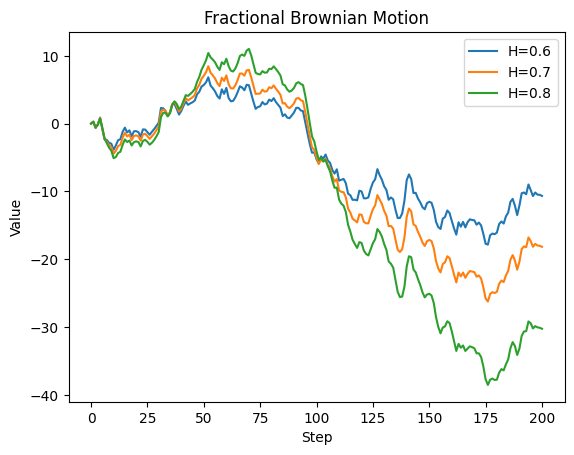

In [ ]:
plt.plot(times,s1,label='H=0.6')
plt.plot(times,s2,label='H=0.7')
plt.plot(times,s3,label='H=0.8')
#plt.plot(times,s4,label='H=0.7')
#plt.plot(times,s5,label='H=0.9')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('Fractional Brownian Motion')
plt.legend()
plt.show()

In [ ]:
scipy.io.savemat('gendata678new.mat', mdict={'s1': s1,'s2':s2,'s3':s3})

In [ ]:
#s = np.concatenate((np.expand_dims(s1,axis=0),np.expand_dims(s2,axis=0),np.expand_dims(s3,axis=0)),axis=0)
s = np.concatenate((np.expand_dims(s1,axis=0),np.expand_dims(s3,axis=0)),axis=0)

In [ ]:
#s1 = np.expand_dims(s1,axis=0)
s0 = s[:,:50]

In [ ]:
#s90 = s90.T
s = s.T

In [ ]:
mod = sm.tsa.VARMAX(s, order=(1,0))

In [ ]:
res = mod.fit(disp=False)

In [ ]:
res.summary()

Dep. Variable:,"['y1', 'y2']",No. Observations:,201
Model:,VAR(1),Log Likelihood,-187.100
,+ intercept,AIC,392.200
Date:,"Thu, 30 Nov 2023",BIC,421.930
Time:,04:39:46,HQIC,404.230
Sample:,0,,
,- 201,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"10.16, 44.77",Jarque-Bera (JB):,"1.31, 12.40"
Prob(Q):,"0.00, 0.00",Prob(JB):,"0.52, 0.00"
Heteroskedasticity (H):,"1.72, 2.16",Skew:,"0.20, 0.36"


In [ ]:
#pred = res.forecast(steps=50)
xpred = res.predict()

In [ ]:
fr= np.genfromtxt('frac678pred.csv',delimiter=',')

In [ ]:
fr = fr.T

In [ ]:
s.shape

(201, 3)

In [ ]:
np.linalg.norm(-s)/np.linalg.norm(s)

0.06812326095976931

In [ ]:
np.linalg.norm(fr[:,1:]-s[:,1:])/np.linalg.norm(s[:,1:])

0.3379734795204285

In [ ]:
np.linalg.norm(np.delete(xpred,1,1)-np.delete(s,1,1))/np.linalg.norm(np.delete(s,1,1))

0.06813245313634285

In [ ]:
spred = np.concatenate((s0[4,:],pred[:,4]),axis = 0)

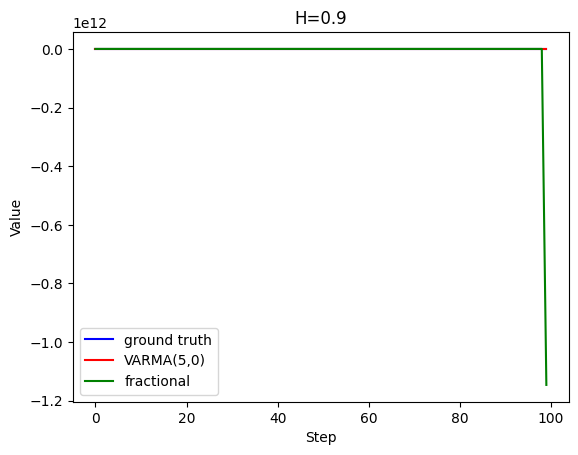

In [ ]:
plt.plot(times[:100],s5[:100],'b',label='ground truth')
plt.plot(times[:100],spred,'r',label='VARMA(5,0)')
plt.plot(times[:100],fr[4,:100],'g',label='fractional')
plt.xlabel('Step')
plt.ylabel('Value')
plt.title('H=0.9')
plt.legend()
plt.show()

In [ ]:
np.sqrt(np.sum(np.square(s2-xpred[:,1]),axis=0)/101)

1.9453144463662257

In [ ]:
np.sqrt(np.sum(np.square(s2-fr[1,:]),axis=0)/101)

0.6723220895816285

In [ ]:
er1 = np.abs(s1[50:100]-pred[:,0])
er2 = np.abs(s2[50:100]-pred[:,1])
er3 = np.abs(s3[50:100]-pred[:,2])
er4 = np.abs(s4[50:100]-pred[:,3])
er5 = np.abs(s5[50:100]-pred[:,4])

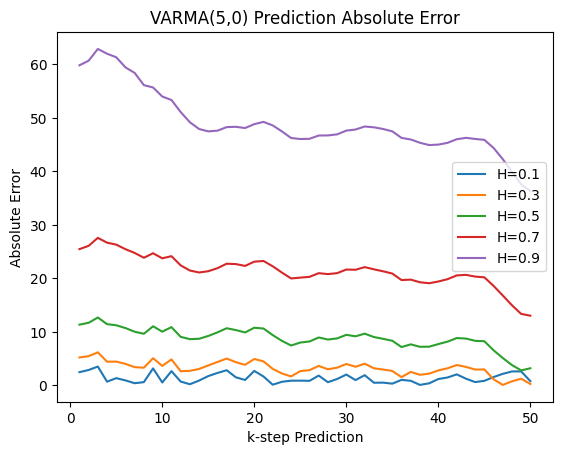

In [ ]:
plt.plot(np.arange(1,51),er1[:50],label='H=0.1')
plt.plot(np.arange(1,51),er2[:50],label='H=0.3')
plt.plot(np.arange(1,51),er3[:50],label='H=0.5')
plt.plot(np.arange(1,51),er4[:50],label='H=0.7')
plt.plot(np.arange(1,51),er5[:50],label='H=0.9')
plt.title('VARMA(5,0) Prediction Absolute Error')
plt.xlabel('k-step Prediction')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

In [ ]:
erfr1 = np.abs(s1[50:100]-fr[0,50:100])

In [ ]:
erfr2 = np.abs(s2[50:100]-fr[1,50:100])
erfr3 = np.abs(s3[50:100]-fr[2,50:100])
erfr4 = np.abs(s4[50:100]-fr[3,50:100])
erfr5 = np.abs(s5[50:100]-fr[4,50:100])

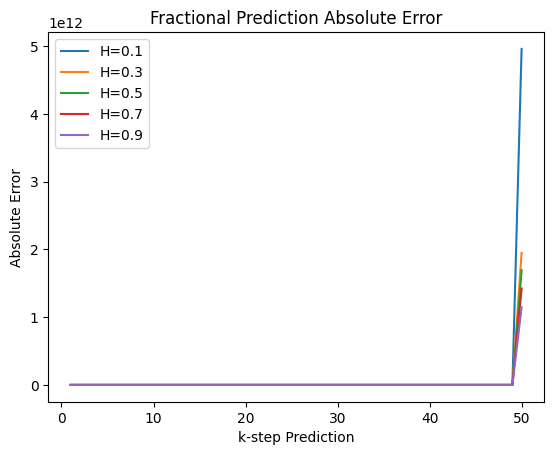

In [ ]:
plt.plot(np.arange(1,51),erfr1[:50],label='H=0.1')
plt.plot(np.arange(1,51),erfr2[:50],label='H=0.3')
plt.plot(np.arange(1,51),erfr3[:50],label='H=0.5')
plt.plot(np.arange(1,51),erfr4[:50],label='H=0.7')
plt.plot(np.arange(1,51),erfr5[:50],label='H=0.9')
plt.title('Fractional Prediction Absolute Error')
plt.xlabel('k-step Prediction')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

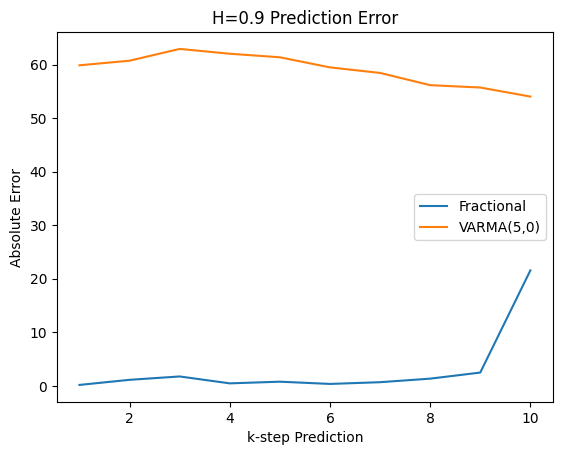

In [ ]:
plt.plot(np.arange(1,11),erfr5[:10],label='Fractional')
plt.plot(np.arange(1,11),er5[:10],label='VARMA(5,0)')
plt.title('H=0.9 Prediction Error')
plt.xlabel('k-step Prediction')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

In [ ]:
alignment = dtw(s5[90:100], fr[4,90:])

In [ ]:
alignment.normalizedDistance

1.167348873858408

In [ ]:
alignment1 = dtw(s5[90:100], pred[:,4])

In [ ]:
alignment1.normalizedDistance

3.3825901145892416

<Axes: xlabel='Query index', ylabel='Reference index'>

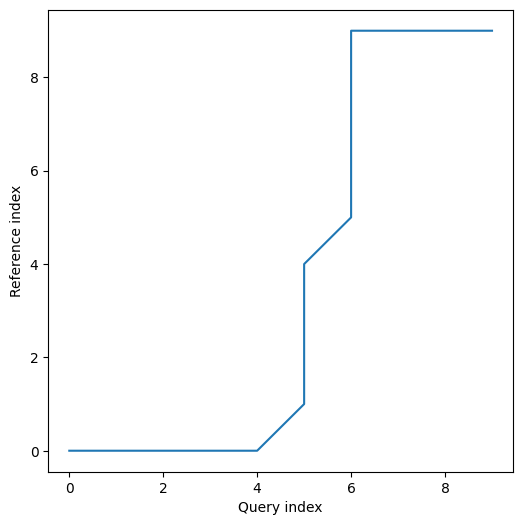

In [ ]:
alignment1.plot()